# Classification

## Deep Learning

### This notebook presents some tests on Classification, using some basic Convolutional Neural Networks.
### The dataset used in this example is the [SVHN](http://ufldl.stanford.edu/housenumbers).

#### This notebook uses Python version 3.6 or newer.

Let's start by checking the Python version.

In [1]:
import sys

if int(sys.version[0]) < 3 or int(sys.version[2]) < 6:
    assert("Python version 3.6 or newer is required")

We continue by importing the necessary libraries and toolkits.

In [2]:
from IPython.display import clear_output
from math import ceil, floor, sqrt
from pandas import DataFrame
from scipy.io import loadmat
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_splitgit@github.com:nbishdev/cnn-svhn-basic.git
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import requests
import seaborn as sns

%matplotlib inline

random.seed(13)

## Data Exploration

We define the functions through which we will download the dataset from the remote host and load it.

In [3]:
def update_progress(progress, file_name):
    bar_length = 100
    block = int(progress)
    clear_output(wait = True)
    text = file_name + ' progress: [' + '#' * block + '-' * (bar_length - block) + '] ' + '{:.1f}'.format(progress) + '%'
    print(text)

def download_svhn_train(path):
    url = 'http://ufldl.stanford.edu/housenumbers/train_32x32.mat'
    file_name = url.split("/")[-1]
    
    if not os.path.exists(path + file_name):
        response = requests.get(url, allow_redirects=True, verify=False, stream=True)

        with open(path + file_name, 'wb') as f:
            total_length = response.headers.get('content-length')

            if total_length is None: # no content length header
                f.write(response.content)
            else:
                dl = 0
                total_length = int(total_length)
                for data in response.iter_content(chunk_size=8192):
                    dl += len(data)
                    f.write(data)
                    done = (100. * dl / total_length)
                    update_progress(done, file_name)
        update_progress(100, file_name)
    
    return path + '/' + file_name

def load_svhn_train(path="./train_32x32.mat"):
    # Load data from .mat file
    data_raw = loadmat(path)
    data = np.array(data_raw['X'])
    
    # Transform data into the correct shape and rescale pixel values
    data = np.moveaxis(data, -1, 0) / 255.0
    labels = data_raw['y']
    
    # Split dataset into training and validation set
    X_train, X_valid, y_train, y_valid = train_test_split(data, labels, test_size=7326)
    
    # Labels --> one-hot encodings
    y_train = to_categorical(y_train.reshape([-1, 1]))
    y_valid = to_categorical(y_valid.reshape([-1, 1]))
    
    return X_train, y_train, X_valid, y_valid, data, labels

Let's download the SVHN dataset and load it into two separate sets:
* A training set
* A validation set

In [4]:
# Download the SVHN dataset 
svhn_path = download_svhn_train('./')

# Load SVHN dataset
X_train, y_train, X_valid, y_valid, data, labels = load_svhn_train(svhn_path)

Let's calculate the distinct classes as well as the number of samples from the dataset that belong to each class.

In [5]:
# Find classes from unique labels and their respective data counts
classes, counts = np.unique(labels, return_counts=True)

Let's print a randomly selected training sample from the dataset.

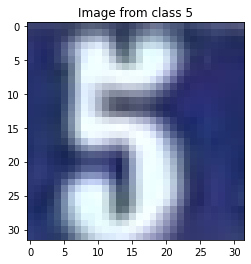

In [6]:
i = random.randint(0, data.shape[0]-1)
plt.title(f"Image from class {labels[i][0] % classes.size}")
plt.imshow(data[i], cmap='Greys')
plt.show()

Let's print a histogram of the counts of the distinct digits in SVHN

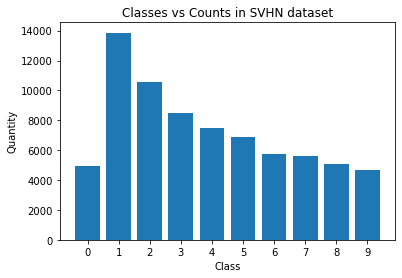

In [7]:
plt.bar(classes % classes.size, counts)
plt.xticks(classes % classes.size)
plt.xlabel("Class")
plt.ylabel("Quantity")
plt.title("Classes vs Counts in SVHN dataset")
plt.show()

We can see that the counts of different lables (digits) are different.

In fact, the number of samples of the digit '1' are about 3 times the number of samples of the digit '9'.

## Experimentation

Now we define a function through which we will build the Neural Network Model.

This function creates a convolutional neural network for multi-class image classification.

We use the <b>categorical_crossentropy</b> loss function and we measure the <b>accuracy</b> of the model.

For the gradient descent optimization, we use <b>Adam</b>.

In [8]:
def build_model(X, y, activation=relu, kernel=(3,3), filters=[9,36,49], units=[32], dropout_rate=0.1, learning_rate=0.01):
    """
    Build a Neural Network model based on the data and the parameters
    """
    # Model creation
    model = Sequential()
    
    # Input layer
    model.add(Input(X.shape[1:]))
    
    # Convolutional and max pooling layers
    for i in range(len(filters)):
        model.add(Conv2D(filters[i], kernel, padding='same', activation=activation))
        model.add(MaxPool2D(kernel))
    
    # Flatten data to feed to the dense layers
    model.add(Flatten())
    
    # Dense layers
    for i in range(len(units)):
        model.add(Dropout(rate=dropout_rate))
        model.add(Dense(units[i], activation=activation))
    
    # Output layer
    model.add(Dense(y.shape[1], activation=softmax))

    # Model compilation and description
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    model.summary()
            
    return model

Let's define the parameters of the neural network model.

We use 3 convolutional layers, each followed by a max pooling layer, and a dense layer at the end with dropout.

We also employ early stopping based on validation loss dropping during the following epoch.

In [9]:
activation = relu
kernel = (3, 3)
filters = [9, 36, 49]
units = [32]
dropout_rate = 0.1
learning_rate = 0.001
epochs = 50

Let's train the model and plot the losses to see what we achieved.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 9)         252       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 9)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 36)        2952      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 36)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 49)          15925     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 49)          0         
_________________________________________________________________
flatten (Flatten)            (None, 49)                0

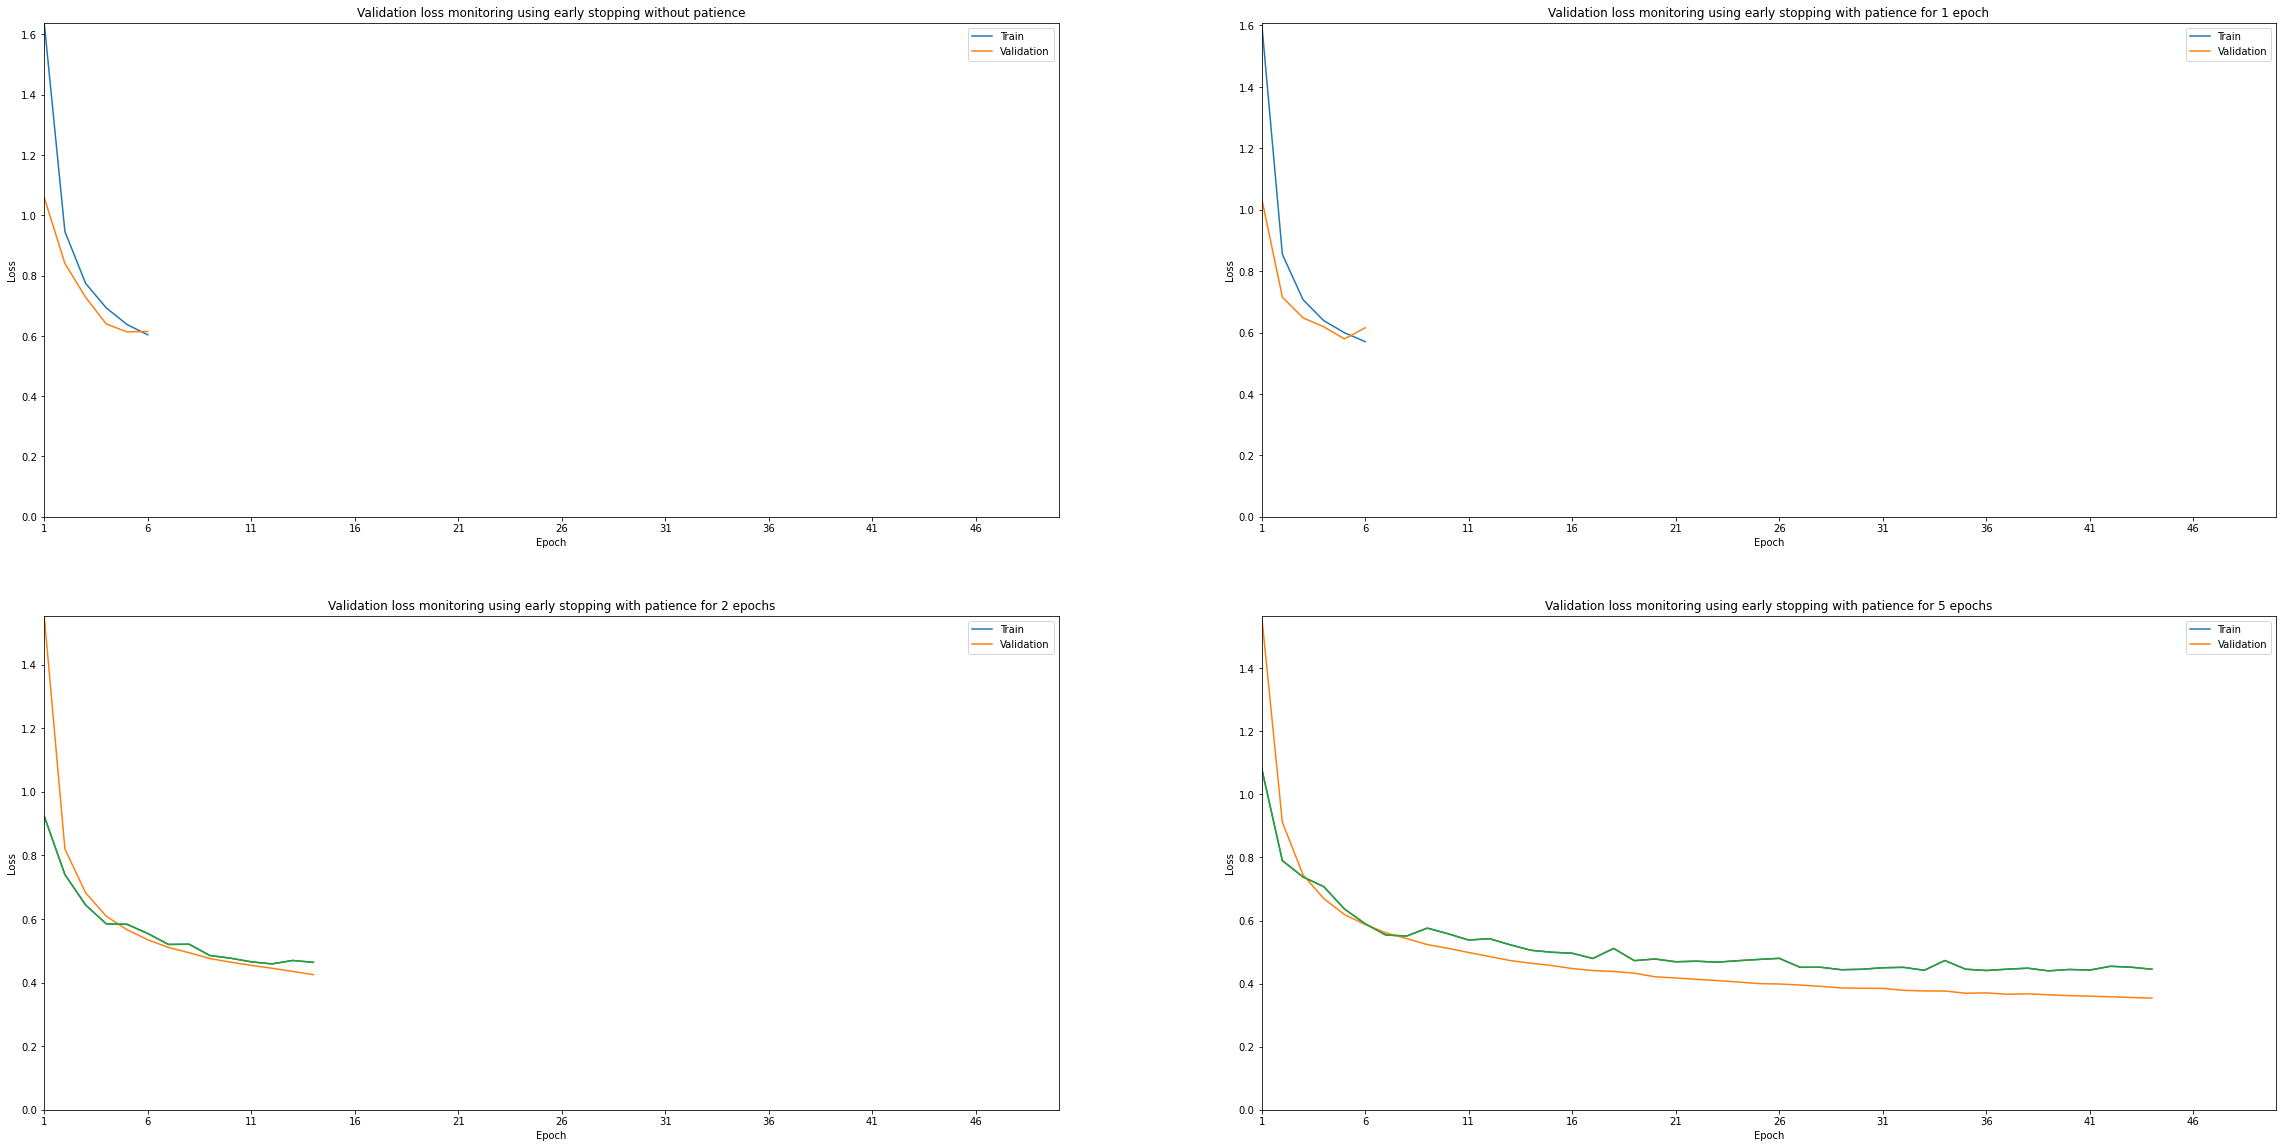

In [10]:
fig = plt.figure(figsize=(40,20))

# No patience, stop immediately
patience = 0
model = build_model(X_train, y_train, relu, kernel, filters, units, dropout_rate, patience, learning_rate)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=patience, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid), callbacks=[early_stopping])

ylim = max(max(history.history['loss']), max(history.history['val_loss']))

# Plot training & validation accuracy losses
plt.subplot(2, 2, 1)
plt.plot(range(1,len(history.epoch)+1),history.history['loss'])
plt.plot(range(1,len(history.epoch)+1),history.history['val_loss'])
plt.title('Validation loss monitoring using early stopping without patience')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.ylim(0., ylim)
plt.xlim(1, epochs)
plt.xticks(range(1,epochs+1,5))

print("_" * 66)

# Patience for one epoch in case validation loss drops after increasing once
patience = 1
model = build_model(X_train, y_train, relu, kernel, filters, units, dropout_rate, patience, learning_rate)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=patience, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid), callbacks=[early_stopping])

ylim = max(max(history.history['loss']), max(history.history['val_loss']))

# Plot training & validation loss values
plt.subplot(2, 2, 2)
plt.plot(range(1,len(history.epoch)+1),history.history['loss'])
plt.plot(range(1,len(history.epoch)+1),history.history['val_loss'])
plt.title('Validation loss monitoring using early stopping with patience for 1 epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.ylim(0., ylim)
plt.xlim(1, epochs)
plt.xticks(range(1,epochs+1,5))

print("_" * 66)

# Patience for five epochs in case validation loss drops after increasing at any of these five epochs
patience = 2
model = build_model(X_train, y_train, relu, kernel, filters, units, dropout_rate, patience, learning_rate)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=patience, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid), callbacks=[early_stopping])

ylim = max(max(history.history['loss']), max(history.history['val_loss']))

# Plot training & validation loss values
plt.subplot(2, 2, 3)
plt.plot(range(1,len(history.epoch)+1),history.history['val_loss'])
plt.plot(range(1,len(history.epoch)+1),history.history['loss'])
plt.plot(range(1,len(history.epoch)+1),history.history['val_loss'])
plt.title('Validation loss monitoring using early stopping with patience for 2 epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.ylim(0., ylim)
plt.xlim(1, epochs)
plt.xticks(range(1,epochs+1,5))

print("_" * 66)

# Patience for ten epochs in case validation loss drops after increasing at any of these ten epochs
patience = 5
model = build_model(X_train, y_train, relu, kernel, filters, units, dropout_rate, patience, learning_rate)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=patience, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid), callbacks=[early_stopping])

ylim = max(max(history.history['loss']), max(history.history['val_loss']))

# Plot training & validation loss values
plt.subplot(2, 2, 4)
plt.plot(range(1,len(history.epoch)+1),history.history['val_loss'])
plt.plot(range(1,len(history.epoch)+1),history.history['loss'])
plt.plot(range(1,len(history.epoch)+1),history.history['val_loss'])
plt.title('Validation loss monitoring using early stopping with patience for 5 epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.ylim(0., ylim)
plt.xlim(1, epochs)
plt.xticks(range(1,epochs+1,5))

plt.show()
# fig.savefig('./loss.png')

### Evaluation

Let's perform a prediction based on the validation data.

In [11]:
# 1-hot encoding to integer
y_valid = np.argmax(y_valid, axis=1)

# Predict classes of test dataset after training
y_pred = model.predict_classes(X_valid)

Let's construct and plot the confusion matrix to see what the model achieved.

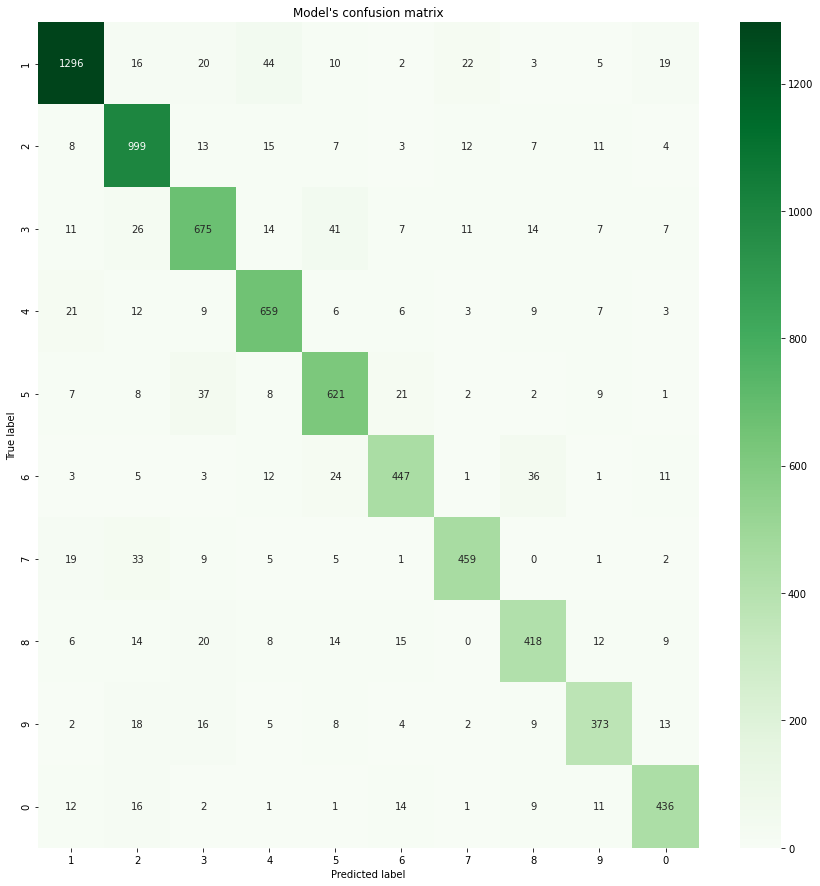

In [12]:
matrix = confusion_matrix(y_valid, y_pred, labels=classes)
df = DataFrame(matrix, index=classes % classes.size, columns=classes % classes.size)

# Plot confusion matrix
fig = plt.figure(figsize=(12,12))

sns.heatmap(df, annot=True, cmap='Greens', fmt='d')
plt.tight_layout()
plt.title("Model's confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()
# fig.savefig('./confusion-matrix.png')

### Visualization

In order to get some intutition about the way the convolutional layers work, we are going to visualize the outputs of the convolutional layers.

We are going to visualize the output of these layers for a randomly selected image of every class.

Let's to create a function which will randomly select one image from each class and return all the selected images.

In [13]:
def get_random_images(data, labels):
    categorized=[]
    for l in np.unique(labels):
        categorized.append((l, np.take(data, np.where(labels[:,0] == l), axis=0)[0,1:]))
    
    images = []
    images_labels = []
    for c in categorized:
        i = random.randint(0, c[1].shape[0]-1)
        images.append(c[1][i])
        images_labels.append(c[0])
    
    return np.array(images, dtype=float), np.array(images_labels)

Let's call the function to select these random images.

In [14]:
images, images_labels = get_random_images(data, labels)

Now, we are going to define a function through which we can visualize the output of a convolutional layer for a specific image.

In [15]:
def visualize_conv_layer(layer_name, image, label):
    layer_output = model.get_layer(layer_name).output
    intermediate_model = Model(inputs=model.input, outputs=layer_output)
    intermediate_prediction = intermediate_model.predict(image.reshape((1,) + image.shape))
    
    units = intermediate_prediction.shape[-1]
    row_size=floor(sqrt(units))
    col_size=ceil(sqrt(units))
    
    img_index=0

    fig, axes = plt.subplots(row_size,col_size, figsize=(12,12))
    for ax in axes:
        for x in ax:
            x.get_xaxis().set_visible(False)
            x.get_yaxis().set_visible(False)
    fig.subplots_adjust(wspace=0, hspace=0)
    plt.grid(False)
    
    for row in range(0,row_size):
        for col in range(0,col_size):
            axes[row][col].imshow(intermediate_prediction[0, :, :, img_index], interpolation='nearest', aspect='auto', cmap='plasma')
            img_index = img_index + 1
    
    fig.suptitle(f'Output of layer {layer_name} for image from class {label}', y=0.9)
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.show()
#     fig.savefig(F'./image-class-{label}-conv-layer-{layer_name}.png', bbox_inches='tight', pad_inches=0)

For every combination of convolutional layers and randomly selected images, we visualize the layer's output.

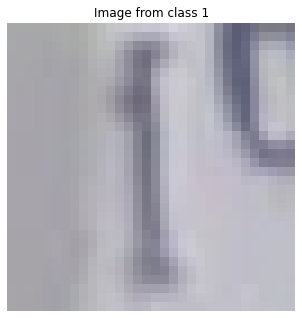

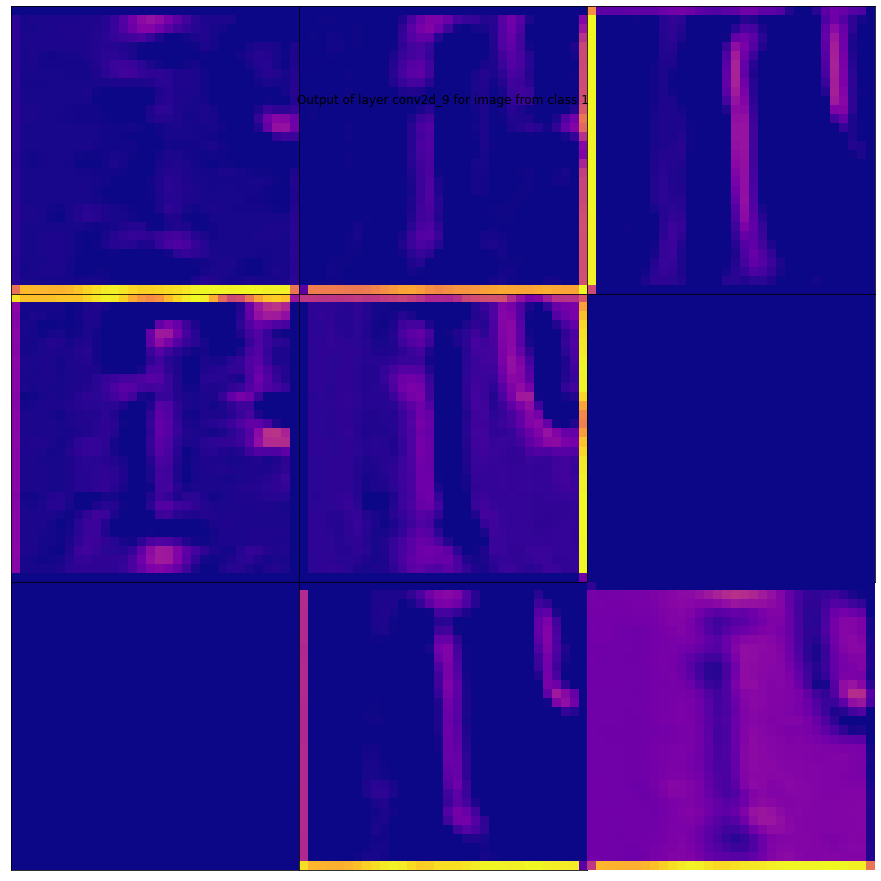

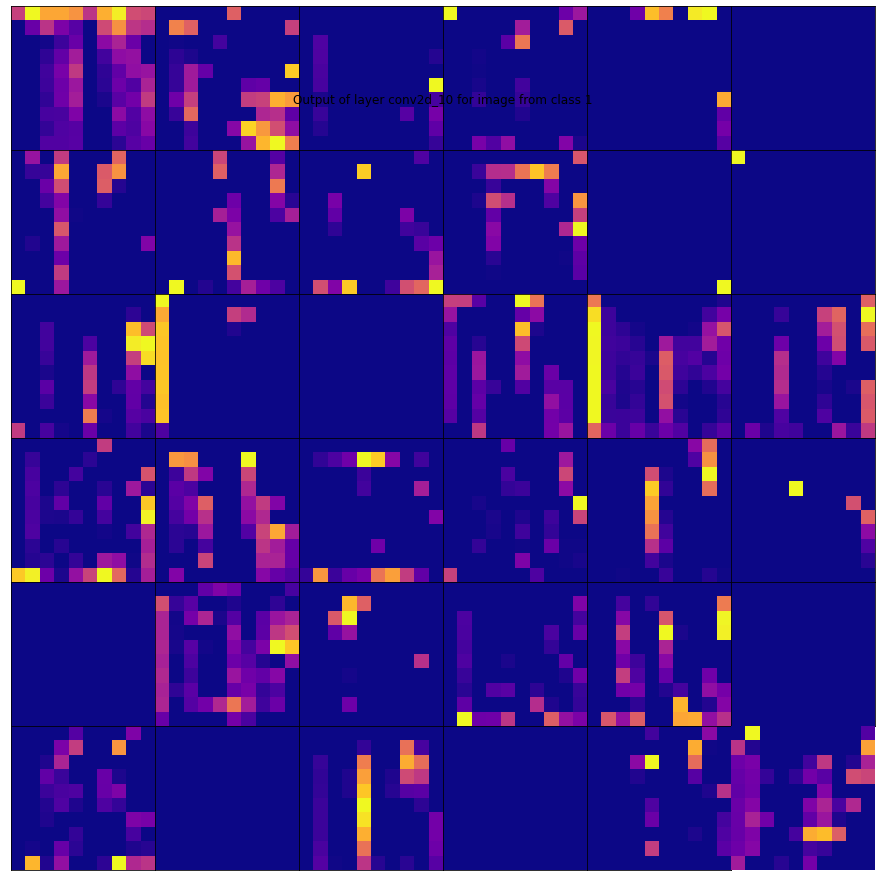

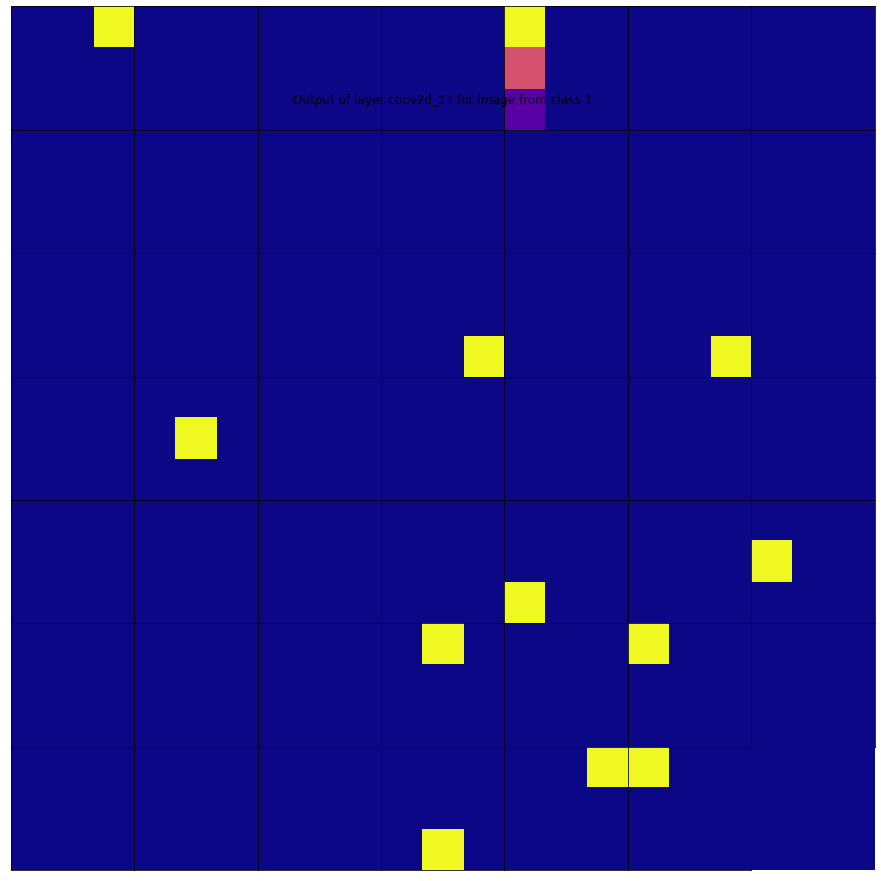

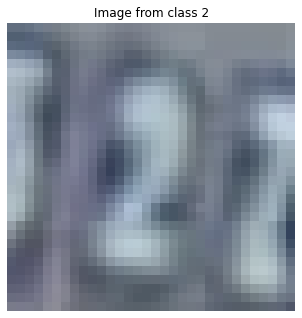

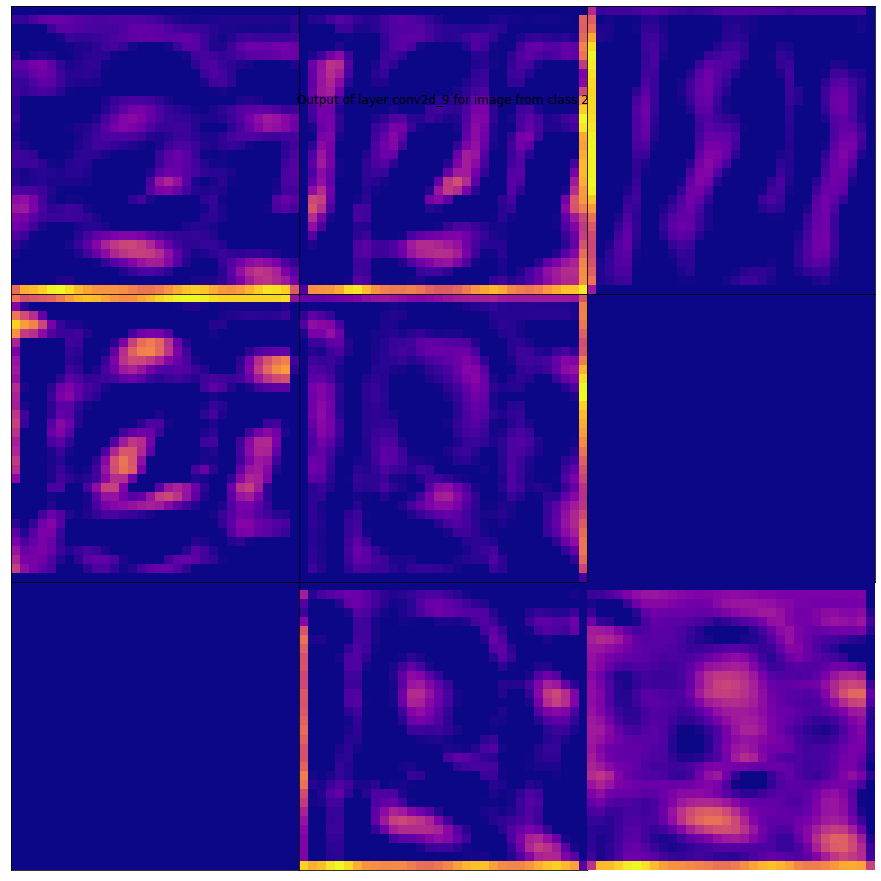

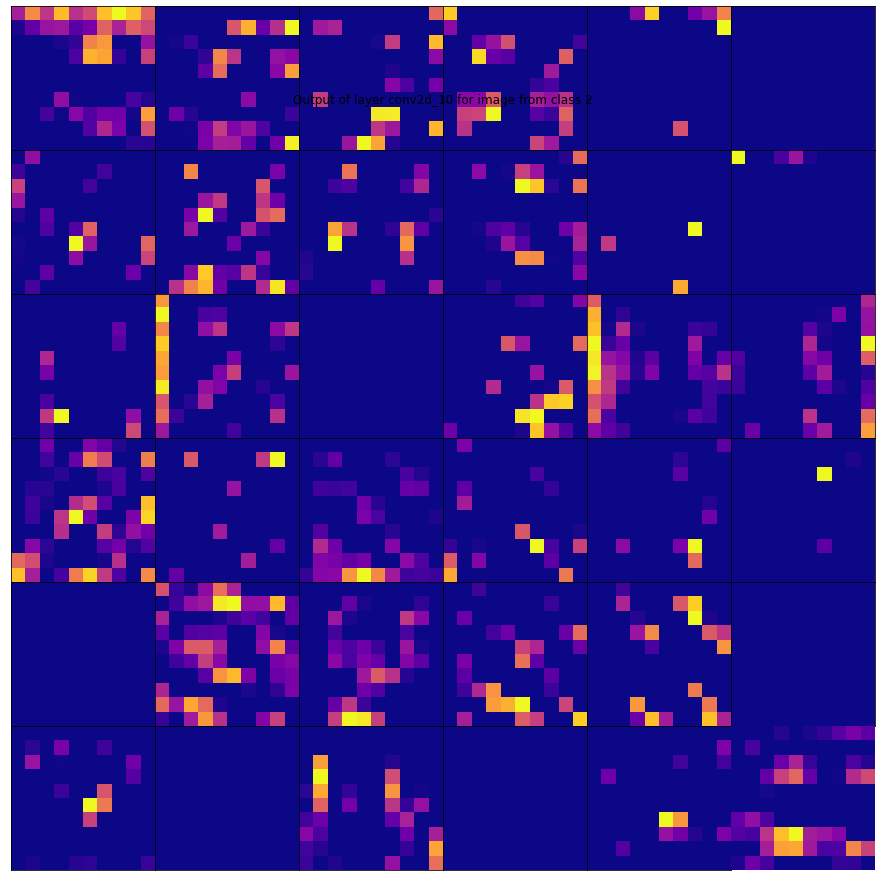

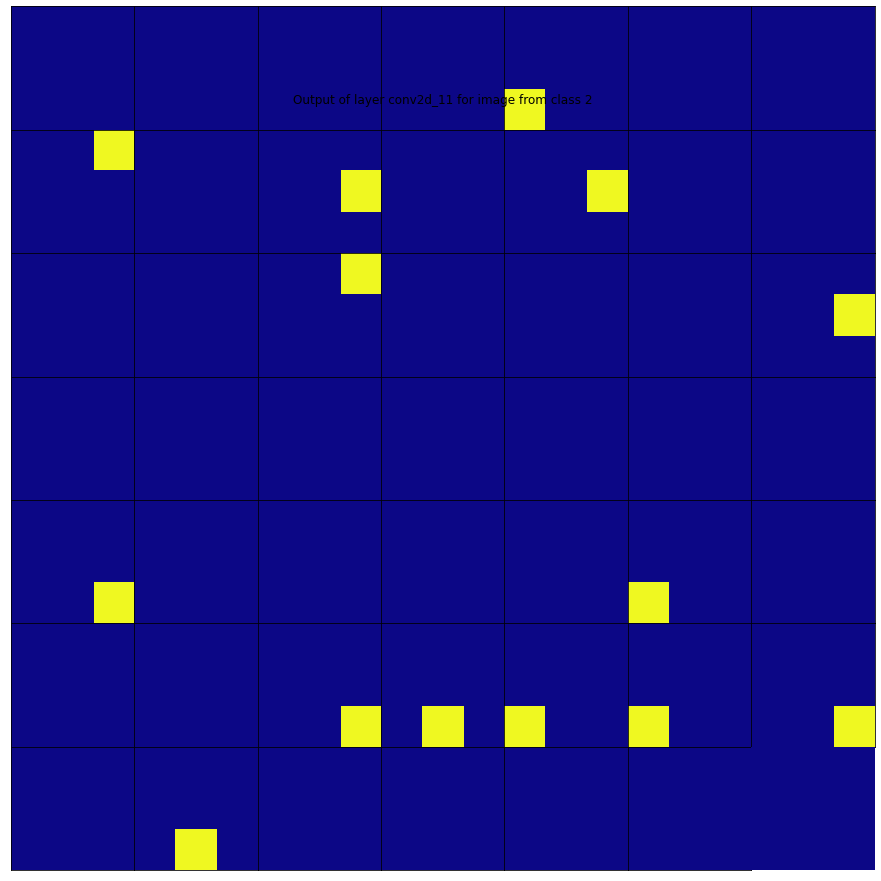

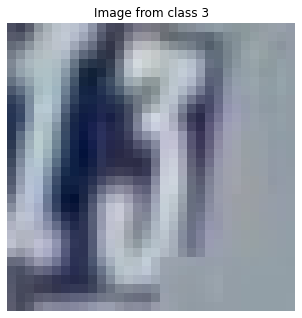

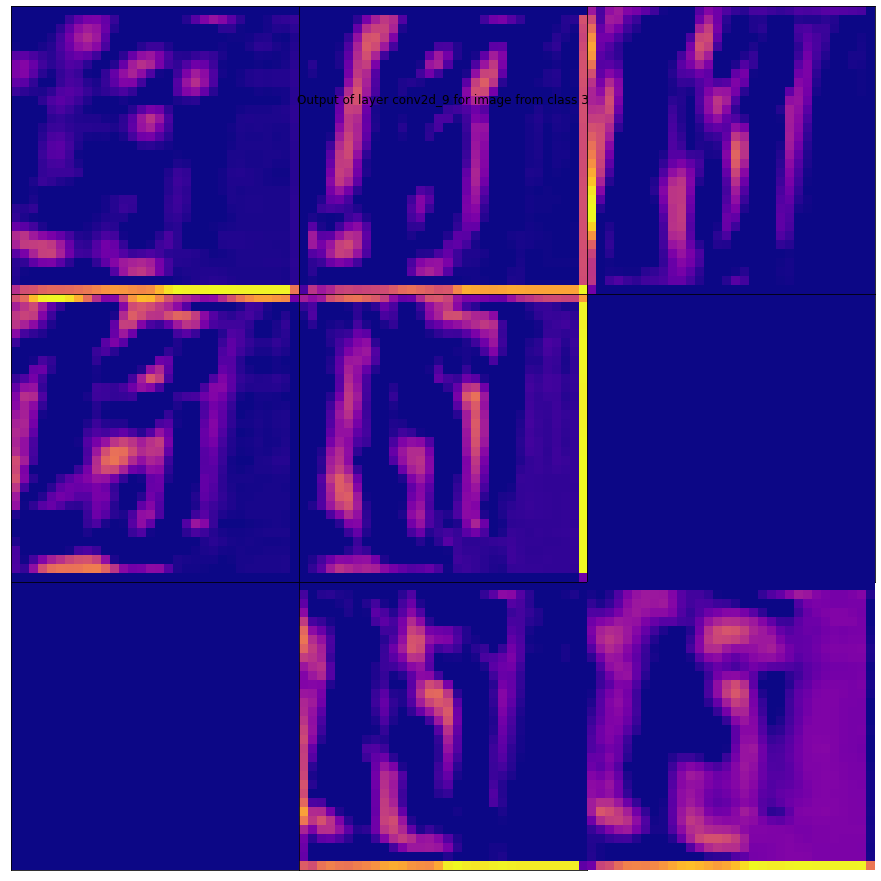

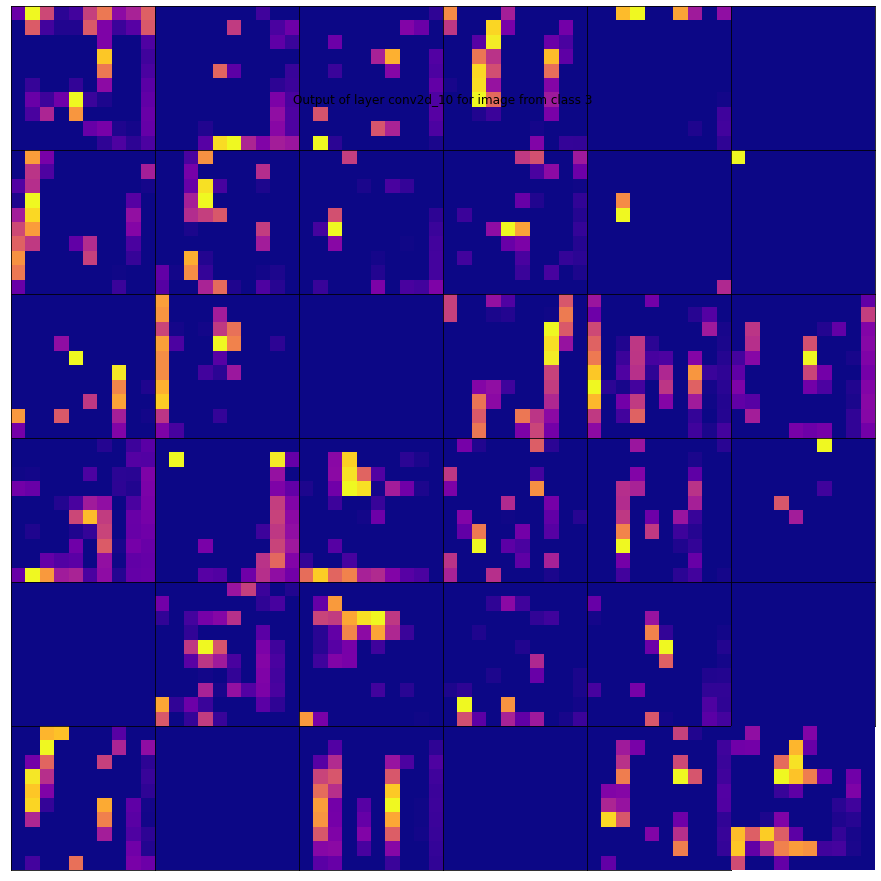

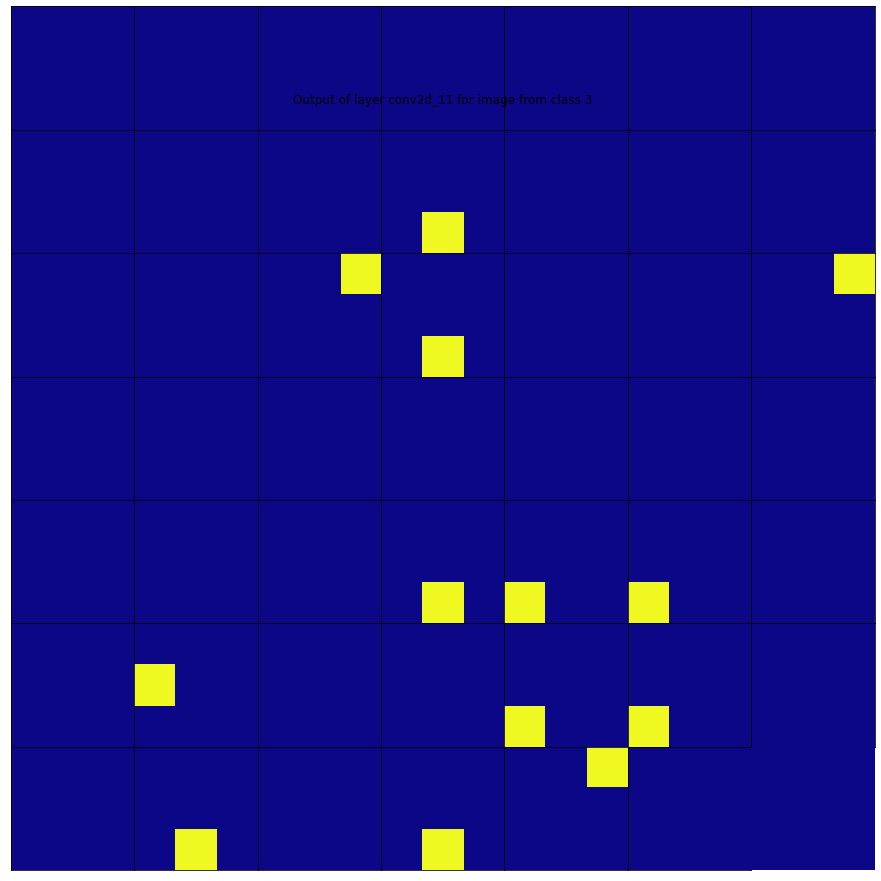

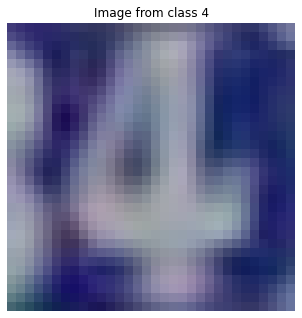

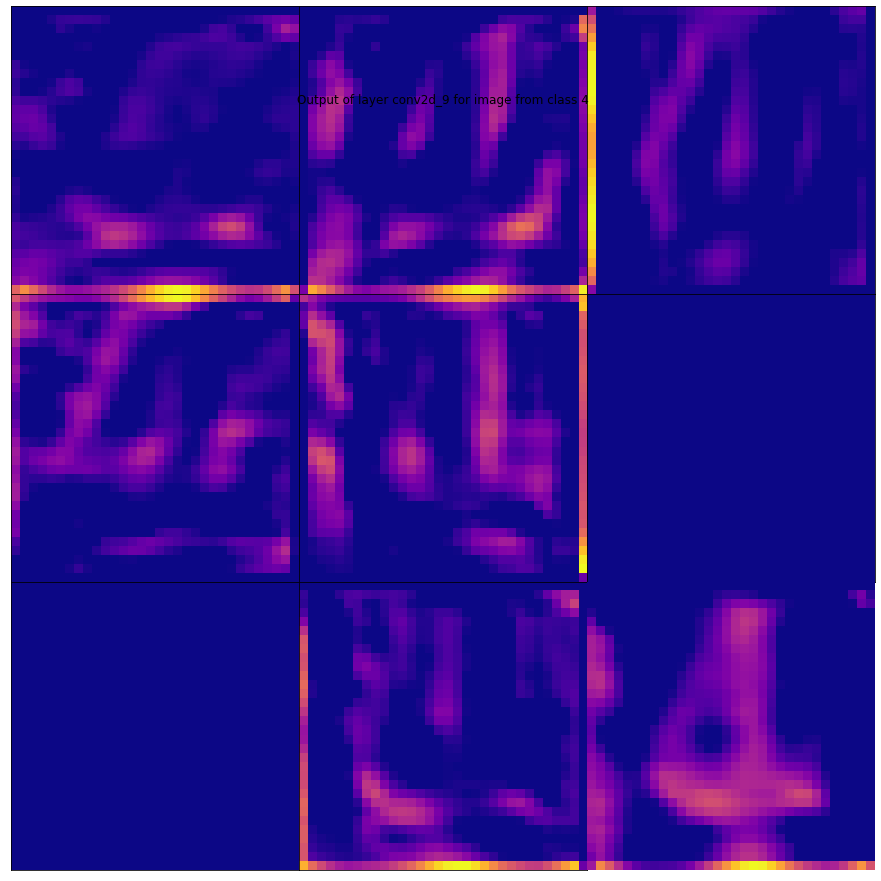

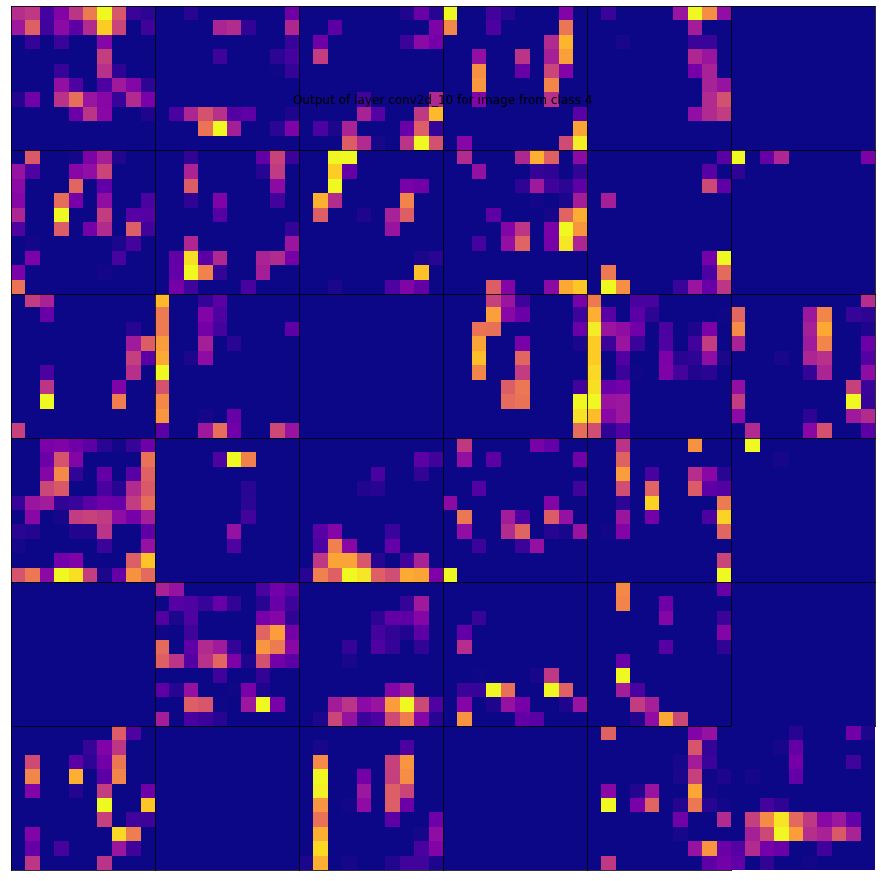

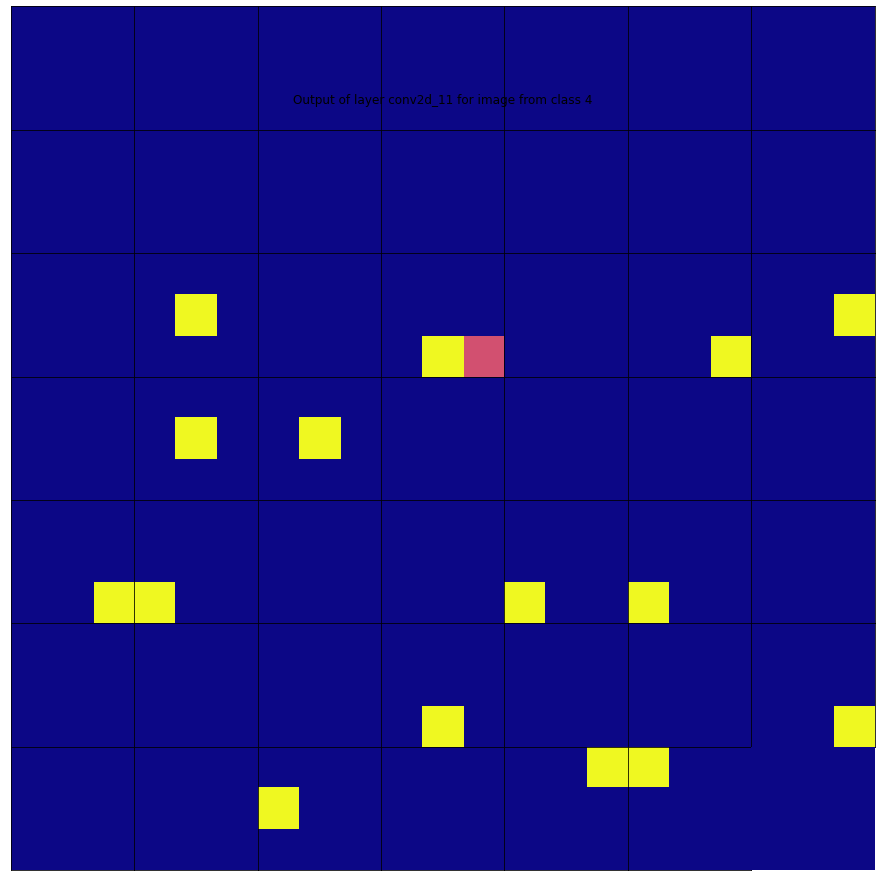

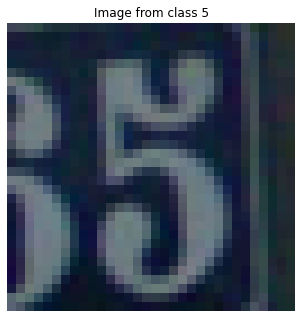

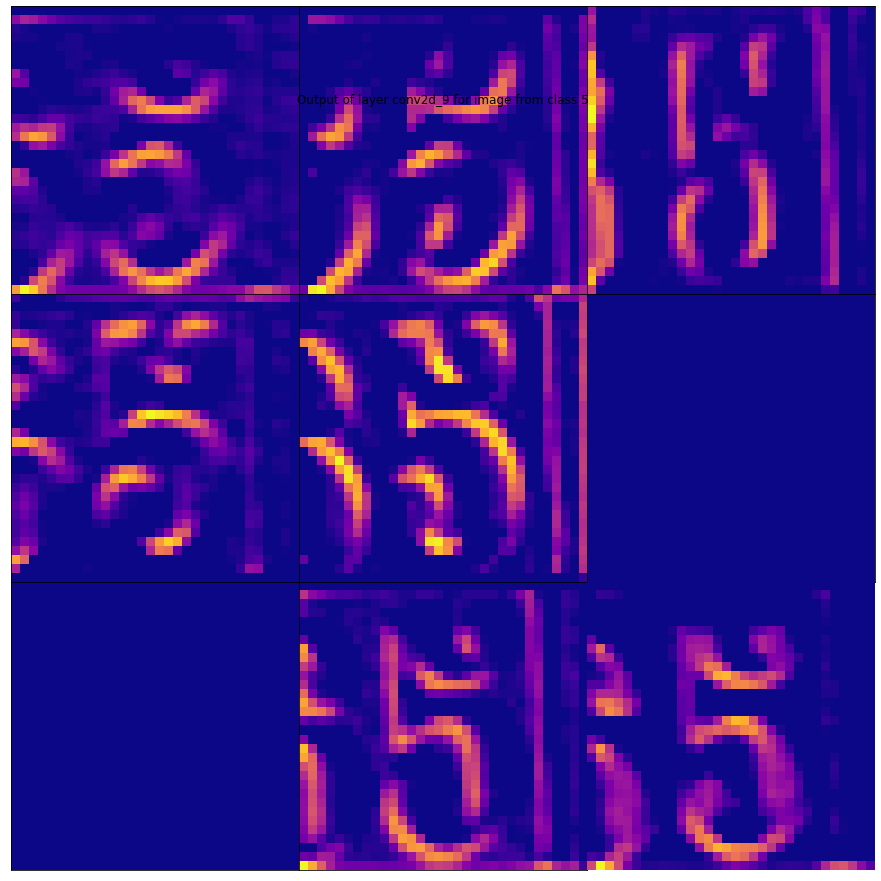

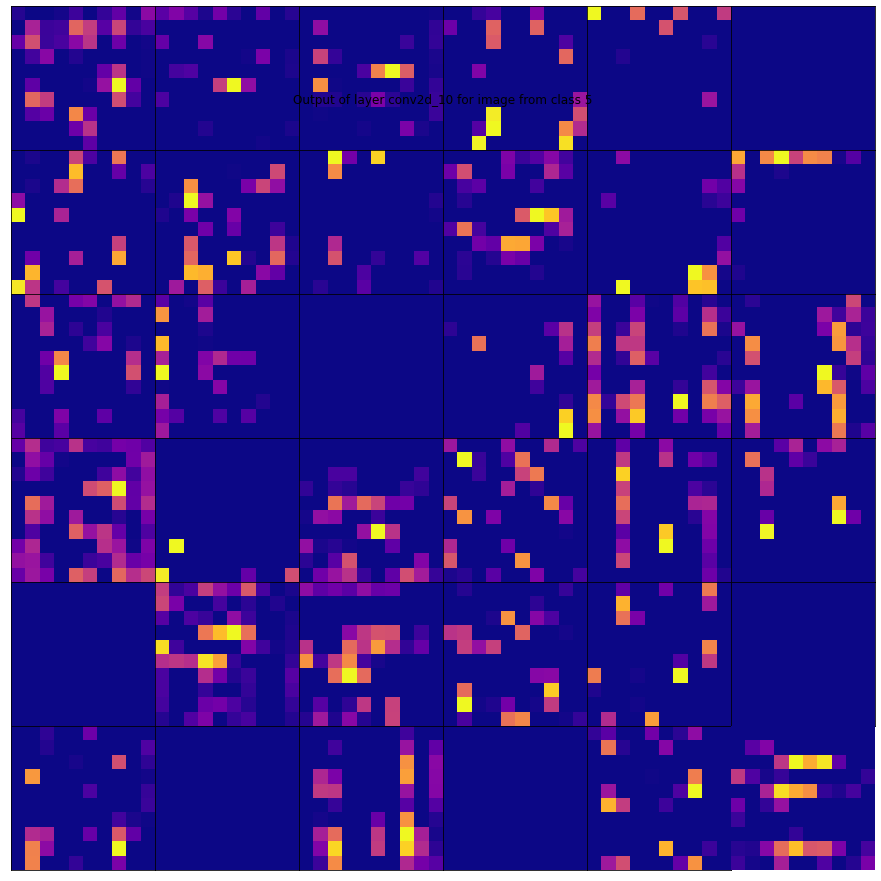

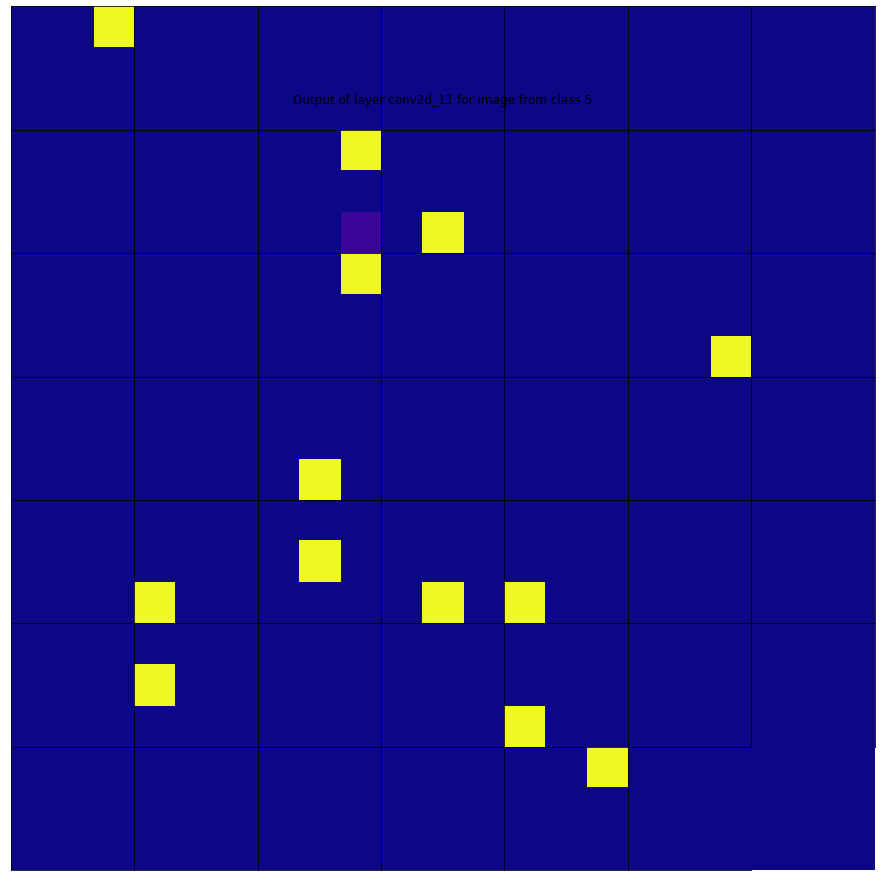

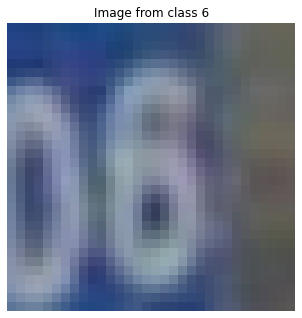

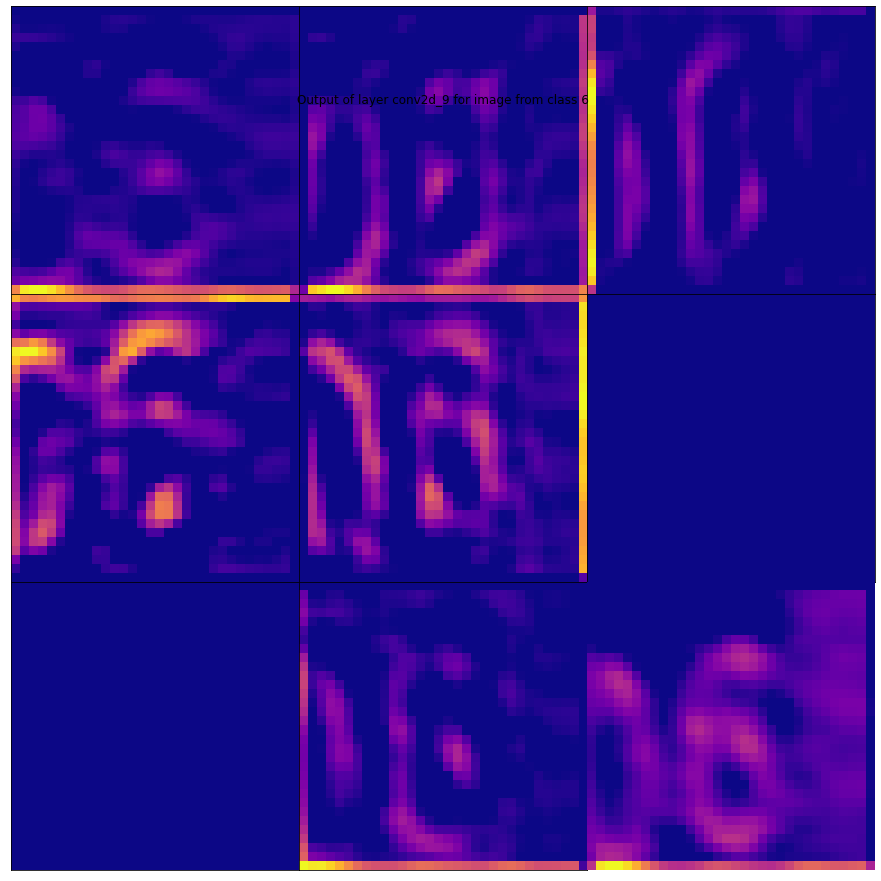

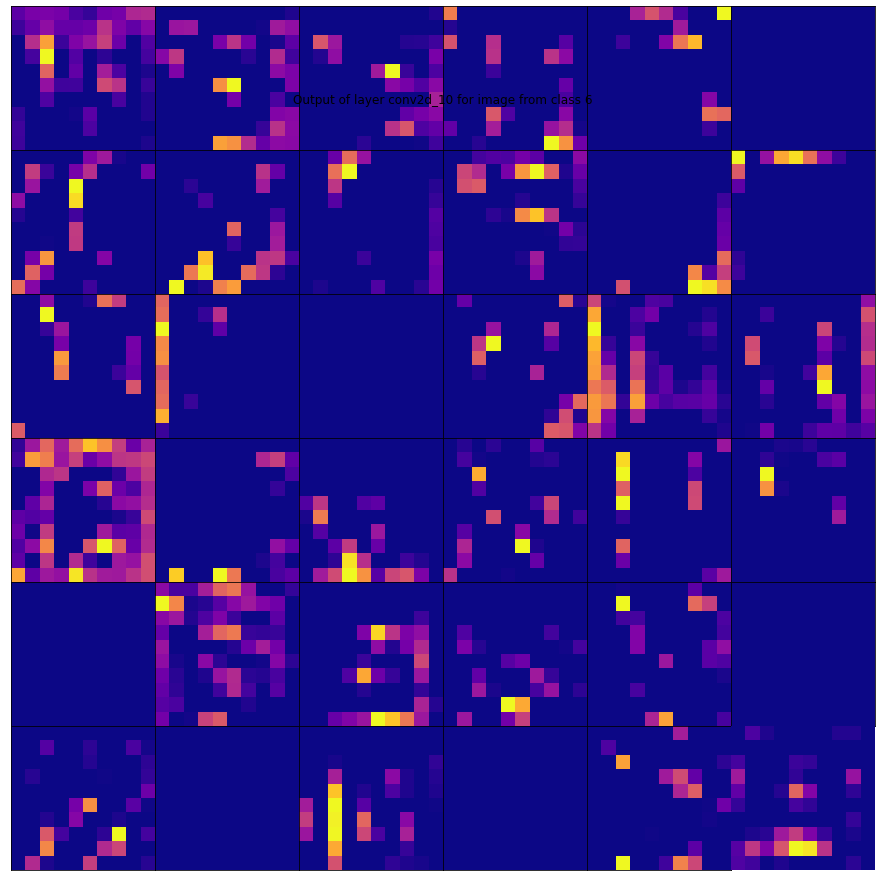

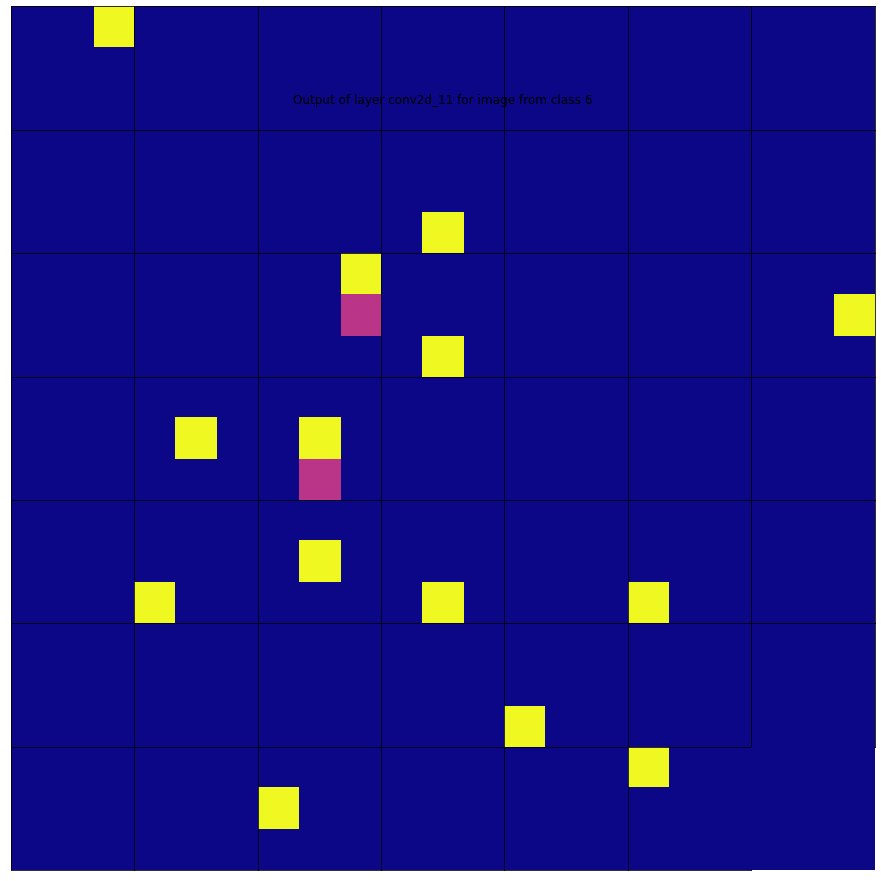

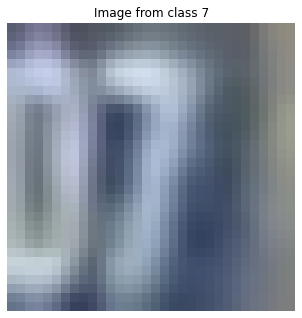

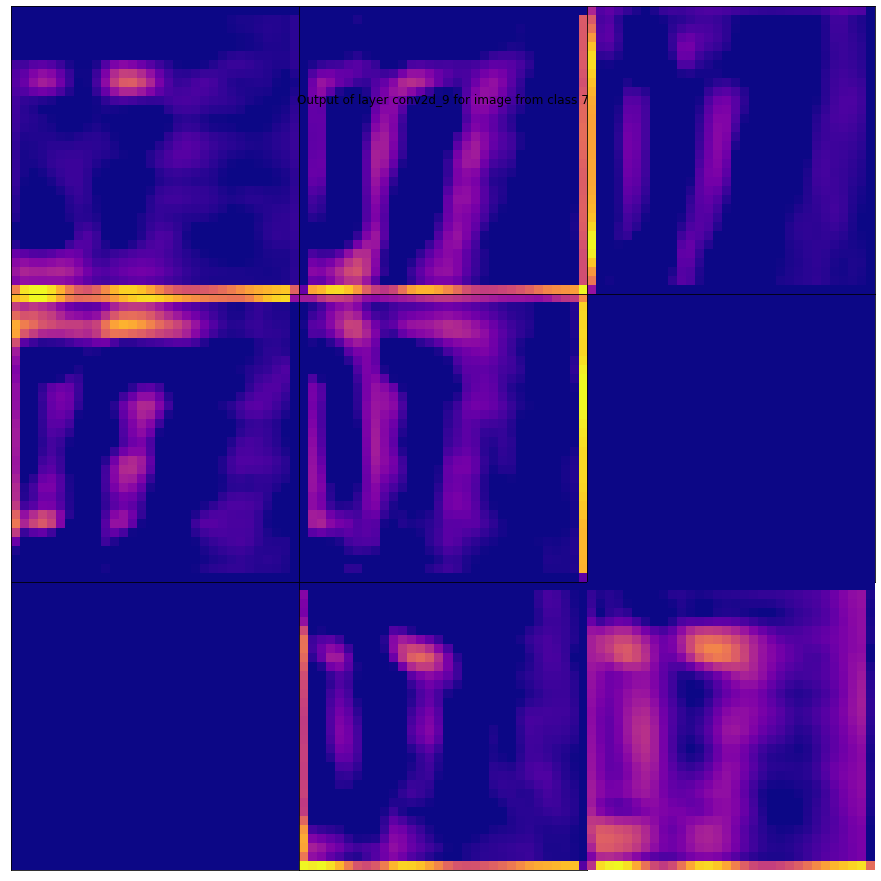

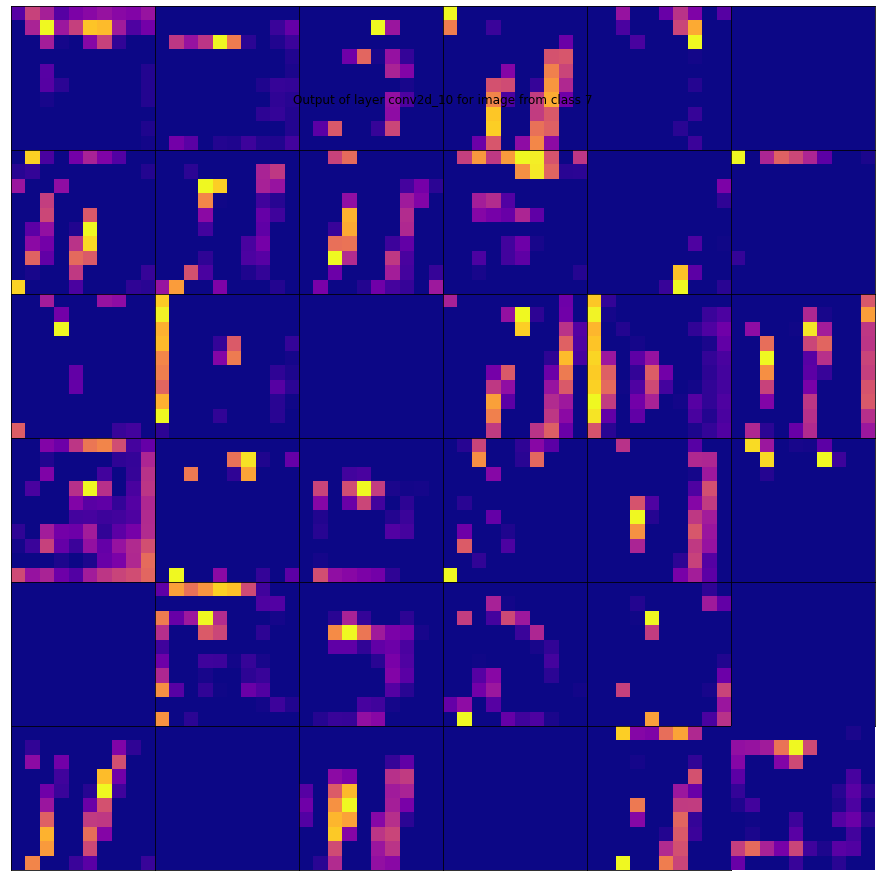

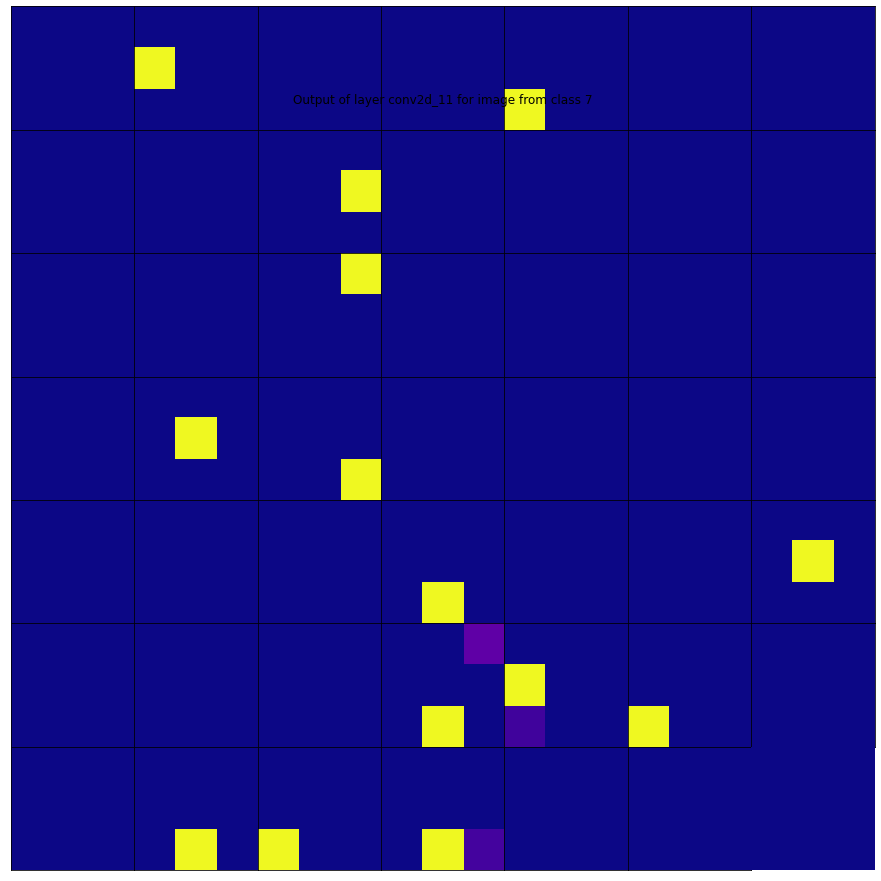

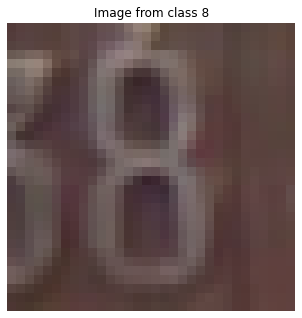

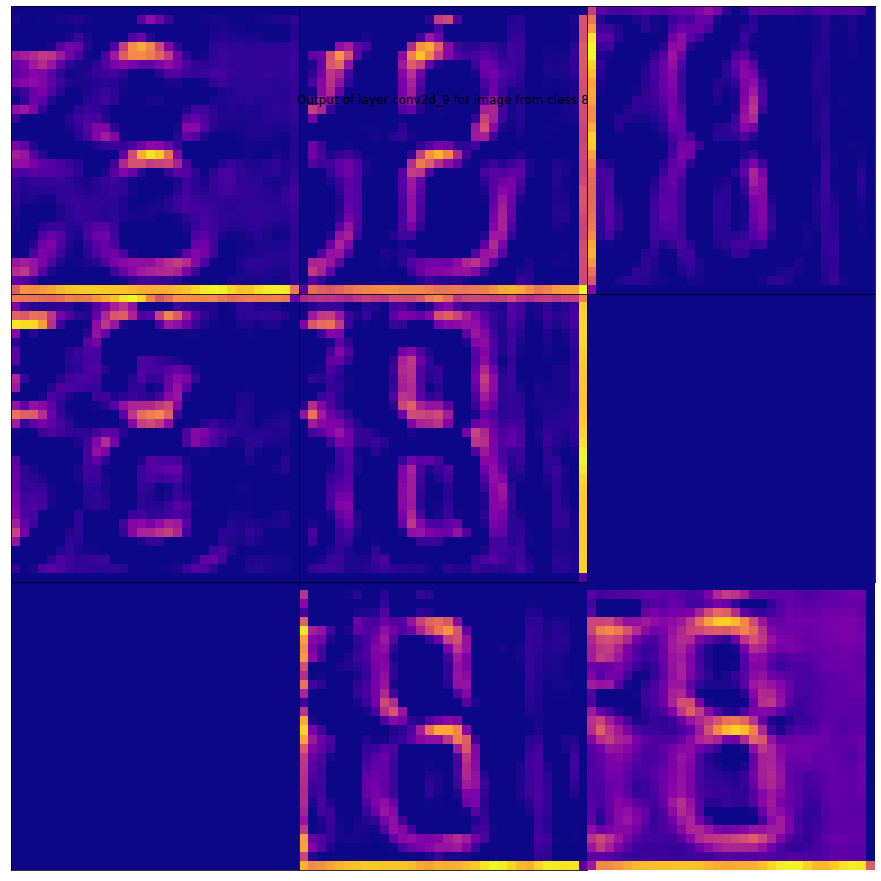

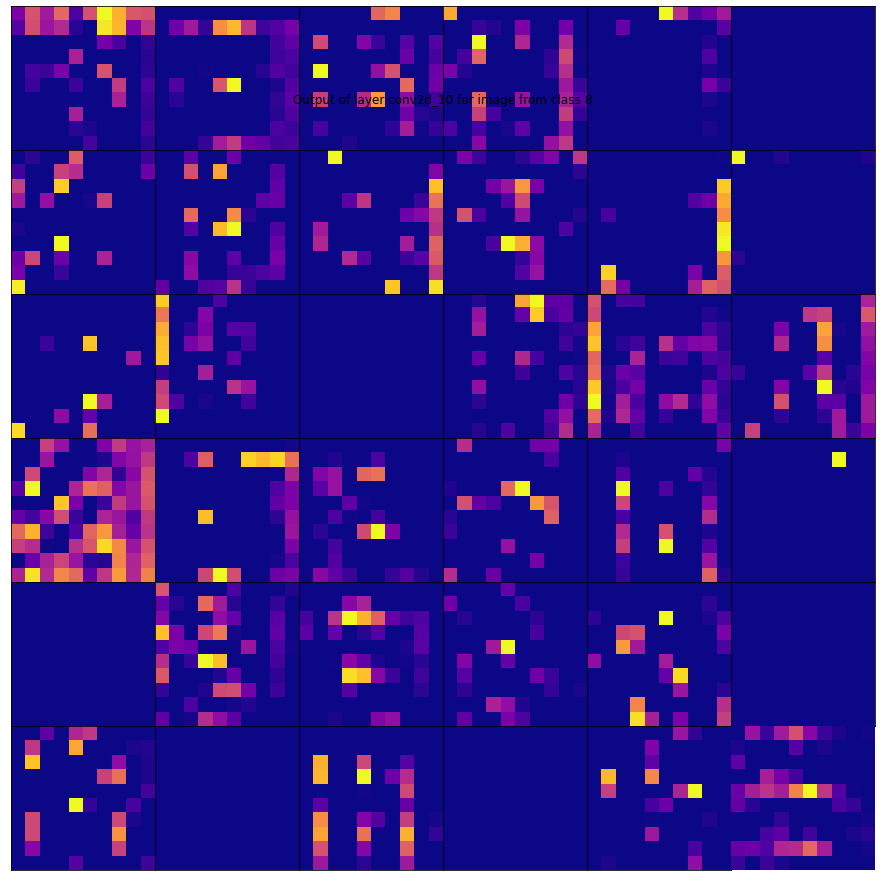

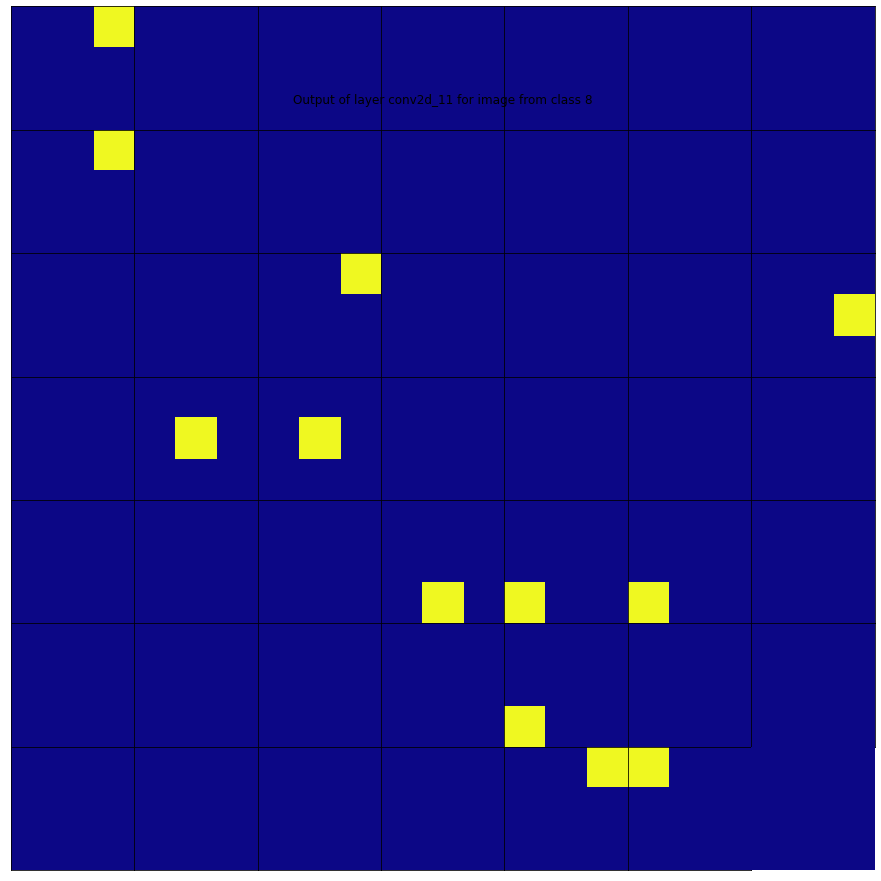

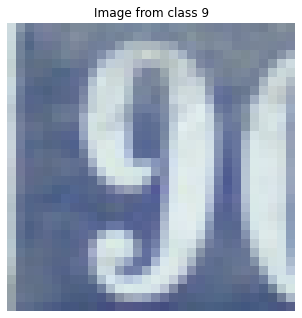

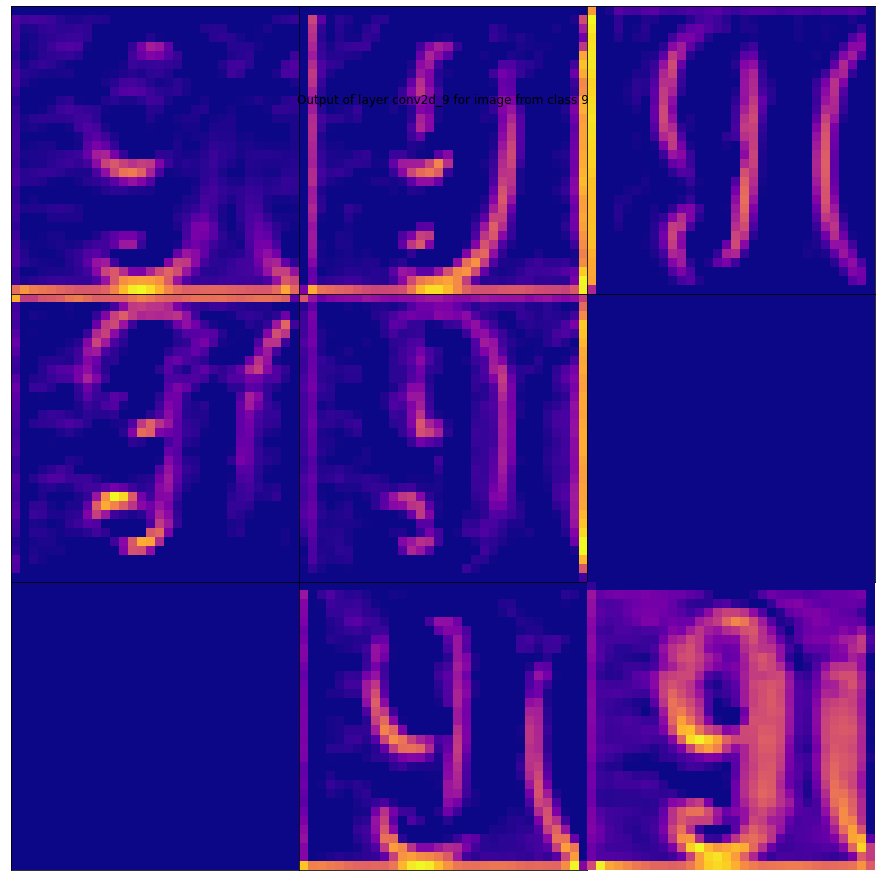

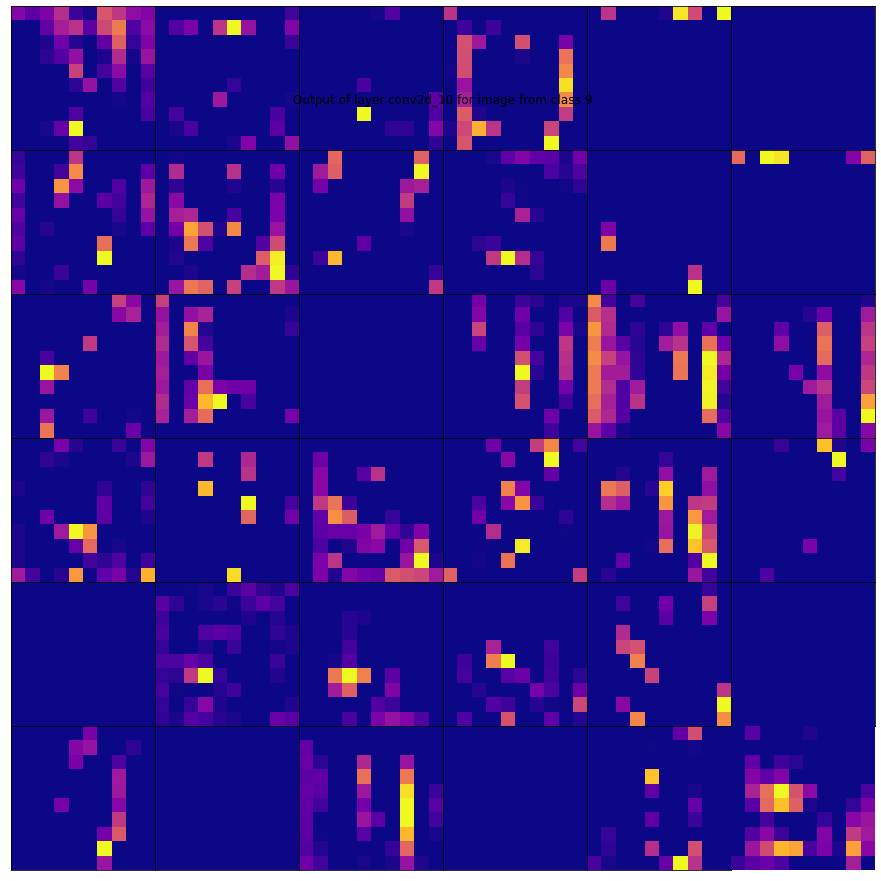

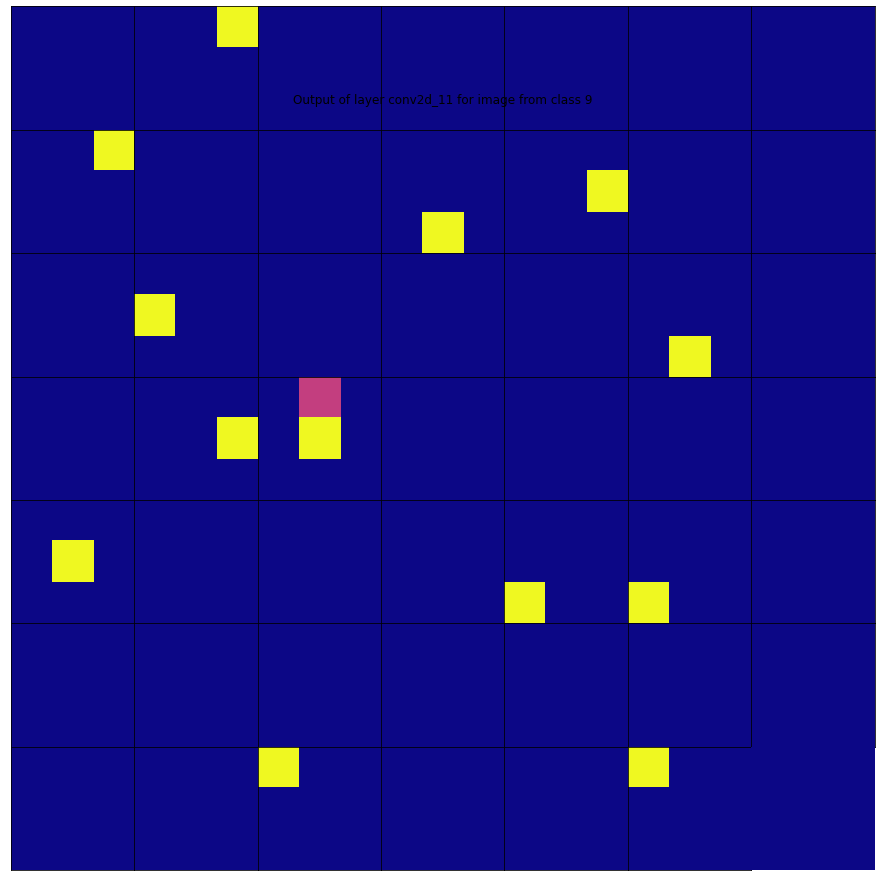

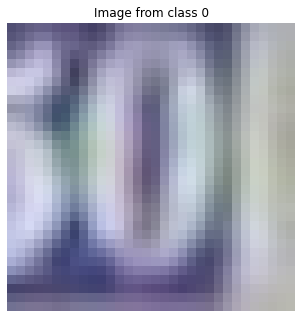

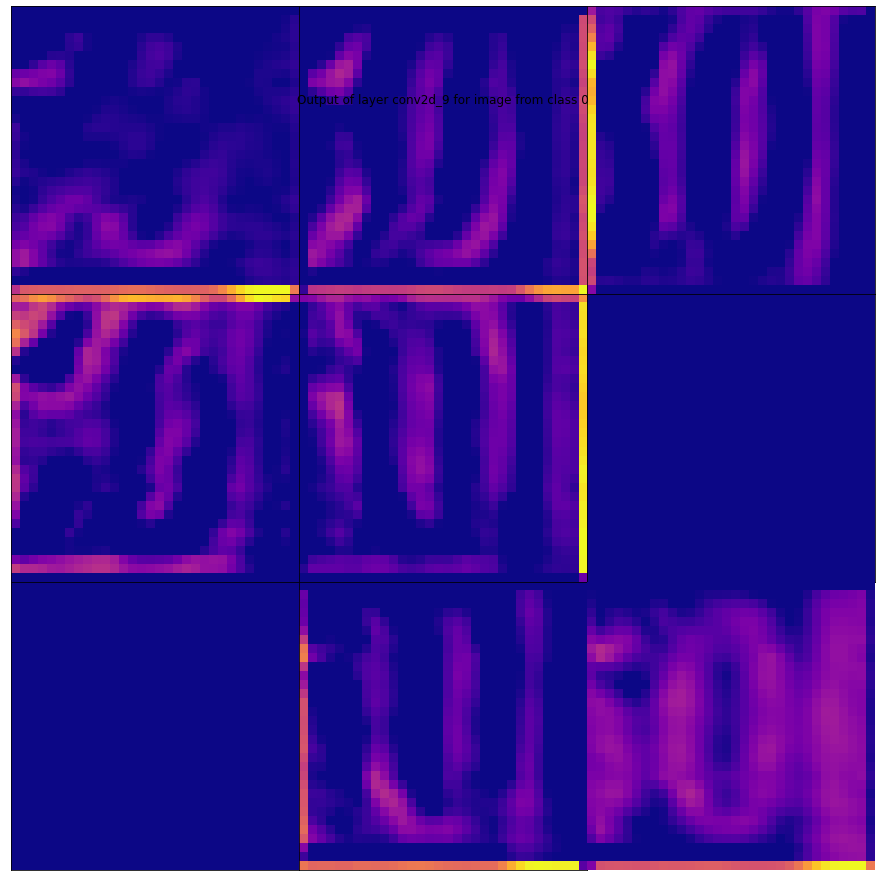

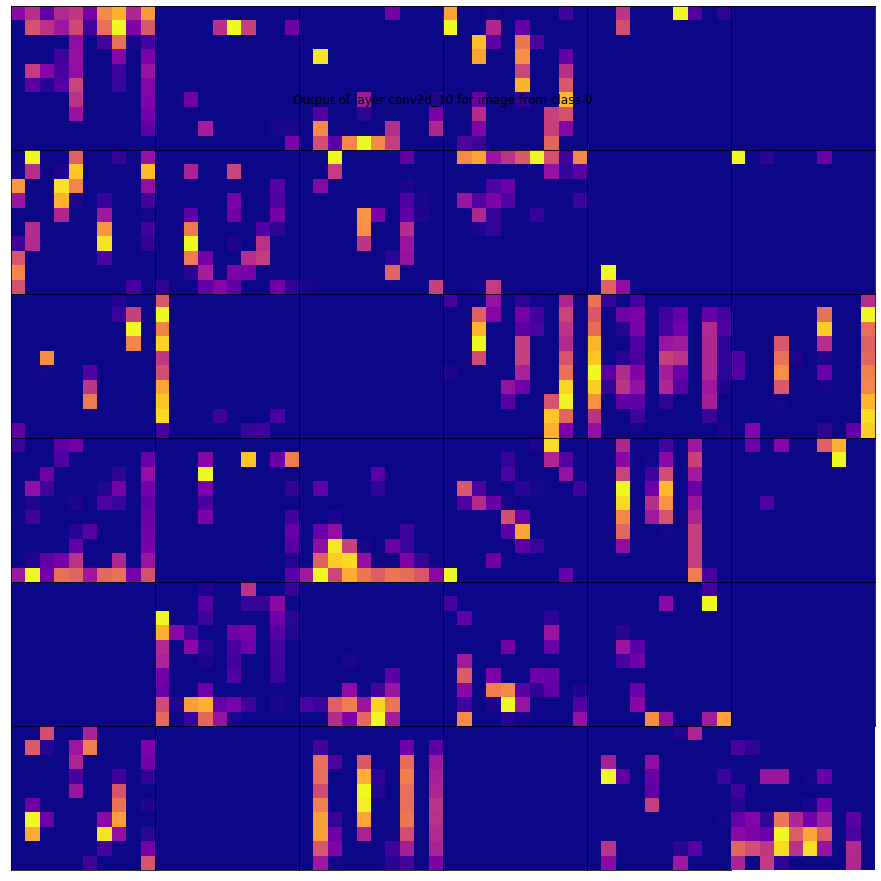

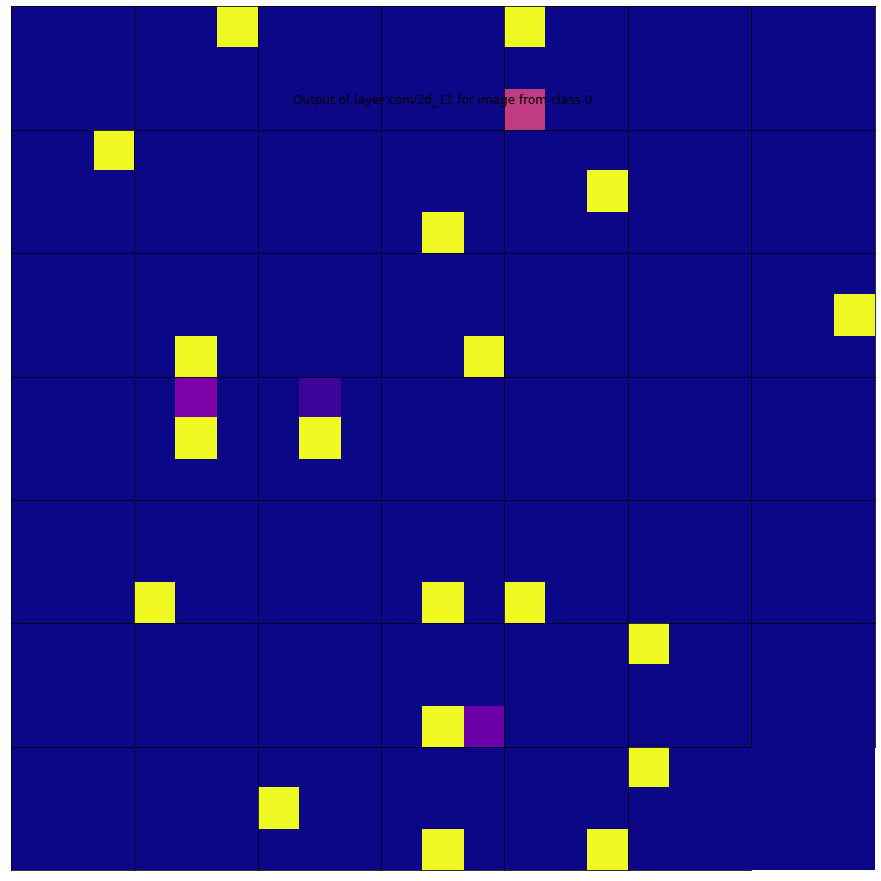

In [16]:
for image, label in zip(images, images_labels):
    fig = plt.figure()
    plt.gca().set_axis_off()
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.imshow(image)
    plt.title(f'Image from class {label % classes.size}')
    plt.show()
#     fig.savefig(f'./image-class-{label}.png', bbox_inches='tight', pad_inches=0)

    for index in range(len(model.layers)):
        layer_name = model.get_layer(index=index).get_config().get('name')
        if 'conv2d' in layer_name:
            visualize_conv_layer(layer_name, image, label % classes.size)

On the first convolutional layer, we can distinguish the house numbers from the background noise, since these are the features that we want for the training.

However,as we move on to the following convolutional layers, these features are less distinct and the actual features that are being used are more like details of the original numbers.